**Dynamic Evaluation: Policy Iteration**

In this notebook, we implement the policy iteration algorithm for the Jack's Car Rental Exampl (Sutton&Barto book, Example 4.2) [adapted from Shangtong Zhang repository]

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from math import exp, factorial
import seaborn as sns

Define the model

In [2]:
MAX_CARS = 20 # maximum # of cars in each location
MAX_MOVE_OF_CARS = 5 # maximum # of cars to move during night

RENTAL_REQUEST_FIRST_LOC = 3 # expectation for rental requests in first location
RENTAL_REQUEST_SECOND_LOC = 4 # expectation for rental requests in second location

RETURNS_FIRST_LOC = 3 # expectation for # of cars returned in first location
RETURNS_SECOND_LOC = 2 # expectation for # of cars returned in second location

DISCOUNT = 0.9

RENTAL_CREDIT = 10 # credit earned by a car
MOVE_CAR_COST = 2 # cost of moving a car

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

Define the Poisson probability

In [3]:
# Probability for poisson distribution
def poisson(n, lam):
    return exp(-lam) * pow(lam, n) / factorial(n)

Define the Expected Return function \sum_{s',r} p(s',r|s,a)[r + γv(s') ]
We will ignore events with Poisson probabilities very low, so we define a POISSON_UPPER_BOUND to limit the loop ranges.

In [4]:
POISSON_UPPER_BOUND = 11

def expected_return(state, action, state_value):
    # @state: [# of cars in first location, # of cars in second location]
    # @action: positive if moving cars from first location to second location,
    #          negative if moving cars from second location to first location
    # @stateValue: state value matrix

    returns = MOVE_CAR_COST * abs(action) # cost for moving cars

    # go through all possible rental requests
    for rental_request_first_loc in range(0, POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(0, POISSON_UPPER_BOUND):
            # moving cars
            num_of_cars_first_loc = int(min(state[0] - action, MAX_CARS))
            num_of_cars_second_loc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            real_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            real_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (real_rental_first_loc + real_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= real_rental_first_loc
            num_of_cars_second_loc -= real_rental_second_loc

            # probability for current combination of rental requests
            prob = poisson(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            # go through all possible returned cars
            for returned_cars_first_loc in range(0, POISSON_UPPER_BOUND):
                for returned_cars_second_loc in range(0, POISSON_UPPER_BOUND):
                    num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                    num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                    prob_ = poisson(returned_cars_first_loc, RETURNS_FIRST_LOC) * \
                            poisson(returned_cars_second_loc, RETURNS_SECOND_LOC) * prob
                    returns += prob_ * (reward + DISCOUNT * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

Start the model

In [5]:
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1)) # Initialize values
policy = np.zeros(value.shape, dtype=int) # Initialize policy
iteration = 0

Policy evaluation

In [ ]:
iteration += 1
# policy evaluation (in-place)
print('Start policy evaluation Loop, Iter %d' % (iteration))
while True:
    new_value = np.copy(value)
    # States loop
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            new_value[i, j] = expected_return([i, j], policy[i, j], new_value)
    value_change = np.abs((new_value - value)).sum()
    print('value change %f' % (value_change))
    value = new_value
    if value_change < 1e-2:
        break


Start policy evaluation Loop, Iter 2
value change 15150.920051
value change 5589.215081
value change 4070.037523
value change 3124.916901
value change 2438.244342
value change 1924.039865
value change 1530.764740
value change 1224.752978
value change 983.572660
value change 791.788272


Policy improvement


In [7]:
# policy improvement
print('Policy Improvement, Iter %d' % (iteration))
new_policy = np.copy(policy)
for i in range(MAX_CARS + 1):
    for j in range(MAX_CARS + 1):
        action_returns = []
        for action in actions:
            if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                action_returns.append(expected_return([i, j], action, value))
            else:
                action_returns.append(-float('inf'))
        new_policy[i, j] = actions[np.argmax(action_returns)]

policy_change = (new_policy != policy).sum()
print('policy changed in %d states' % (policy_change))
policy = new_policy

Policy Improvement, Iter 1.000000
policy changed in 440 states


Display current policy and value of states

Text(0.5, 1.0, 'policy 1')

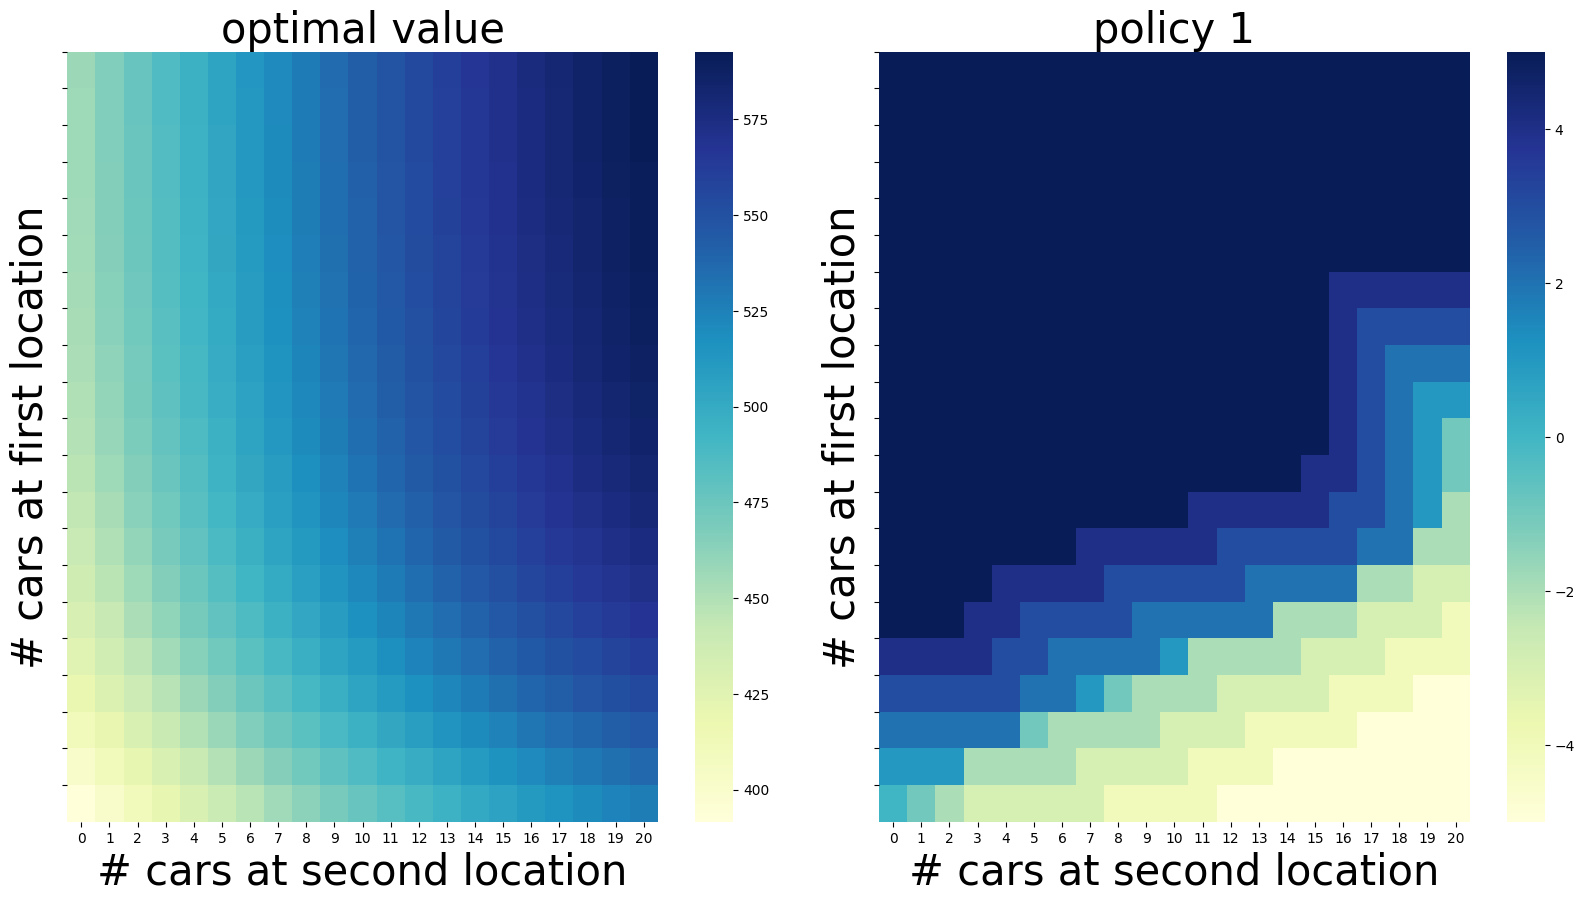

In [8]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

# Display current Values
axes[0] = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[0])
axes[0].set_ylabel('# cars at first location', fontsize=30)
axes[0].set_yticks(list(reversed(range(MAX_CARS + 1))))
axes[0].set_xlabel('# cars at second location', fontsize=30)
axes[0].set_title('optimal value', fontsize=30)

# Display current Policy
axes[1] = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[1])
axes[1].set_ylabel('# cars at first location', fontsize=30)
axes[1].set_yticks(list(reversed(range(MAX_CARS + 1))))
axes[1].set_xlabel('# cars at second location', fontsize=30)
axes[1].set_title('policy %d' % (iteration), fontsize=30)


